# Dependencies

In [ ]:
!pip install huggingface_hub
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00


In [ ]:
!mkdir data_original
!mkdir data_cleaned_original_split
!mkdir data_cleaned_merged
!mkdir data_cleaned_balanced_split

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!pip install transformers
!pip install nltk

import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Loading and transforming dataset into the required form

In [ ]:
from datasets import load_dataset

ds = load_dataset("opennyaiorg/InLegalNER")

train_dataset = load_dataset("opennyaiorg/InLegalNER", split="train")
dev_dataset = load_dataset("opennyaiorg/InLegalNER", split="dev")
test_dataset  = load_dataset("opennyaiorg/InLegalNER", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.14k [00:00<?, ?B/s]

(…)-00000-of-00001-de25c1ae1db42f79.parquet:   0%|          | 0.00/3.53M [00:00<?, ?B/s]

(…)-00000-of-00001-b148266485fd7aeb.parquet:   0%|          | 0.00/389k [00:00<?, ?B/s]

(…)-00000-of-00001-814a730def5e8488.parquet:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10995 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1074 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4501 [00:00<?, ? examples/s]

In [ ]:
train_df = pd.DataFrame(train_dataset)
dev_df = pd.DataFrame(dev_dataset)
test_df = pd.DataFrame(test_dataset)

In [ ]:
train_df["annotations"][0]

[{'result': [{'from_name': 'label',
    'id': 'C8HPTIM1',
    'to_name': 'text',
    'type': 'labels',
    'value': {'end': 103,
     'labels': ['ORG'],
     'start': 90,
     'text': 'Hongkong Bank'}},
   {'from_name': 'label',
    'id': 'KOWE3RAM',
    'to_name': 'text',
    'type': 'labels',
    'value': {'end': 278,
     'labels': ['ORG'],
     'start': 267,
     'text': 'Rahul & Co.'}}]}]

In [ ]:
train_df["data"][0]

{'text': "\n\n(7) On specific query by the Bench about an entry of Rs. 1,31,37,500 on deposit side of Hongkong Bank account of which a photo copy is appearing at p. 40 of assessee's paper book, learned authorised representative submitted that it was related to loan from broker, Rahul & Co. on the basis of his submission a necessary mark is put by us on that photo copy."}

In [ ]:
tags = [
    "COURT",
    "PETITIONER",
    "RESPONDENT",
    "JUDGE",
    "LAWYER",
    "DATE",
    "ORG",
    "GPE",
    "STATUTE",
    "PROVISION",
    "PRECEDENT",
    "CASE_NUMBER",
    "WITNESS",
    "OTHER_PERSON",
]

ner_tags = ["O"] + [item for x in tags for item in (f"B-{x}", f"I-{x}")]
index2tag = {idx: tag for idx, tag in enumerate(ner_tags)}
tag2index = {tag: idx for idx, tag in enumerate(ner_tags)}

In [ ]:
index2tag

{0: 'O',
 1: 'B-COURT',
 2: 'I-COURT',
 3: 'B-PETITIONER',
 4: 'I-PETITIONER',
 5: 'B-RESPONDENT',
 6: 'I-RESPONDENT',
 7: 'B-JUDGE',
 8: 'I-JUDGE',
 9: 'B-LAWYER',
 10: 'I-LAWYER',
 11: 'B-DATE',
 12: 'I-DATE',
 13: 'B-ORG',
 14: 'I-ORG',
 15: 'B-GPE',
 16: 'I-GPE',
 17: 'B-STATUTE',
 18: 'I-STATUTE',
 19: 'B-PROVISION',
 20: 'I-PROVISION',
 21: 'B-PRECEDENT',
 22: 'I-PRECEDENT',
 23: 'B-CASE_NUMBER',
 24: 'I-CASE_NUMBER',
 25: 'B-WITNESS',
 26: 'I-WITNESS',
 27: 'B-OTHER_PERSON',
 28: 'I-OTHER_PERSON'}

In [ ]:
def tokenize_with_positions(text):
    tokens_with_positions = {}
    tokens = word_tokenize(text)

    # NLTK converts double quotes during tokenization
    tokens = ['"' if token == "''" or token == "``" else token for token in tokens]

    start_pos = 0
    for index, token in enumerate(tokens):
        start_pos = text.find(token, start_pos)

        tokens_with_positions[start_pos] = {
            "token": token,
            "index": index
        }
        start_pos += len(token)

    return tokens, tokens_with_positions

def assign_labels(tokens, tokens_with_positions, annotations):
    positions = tokens_with_positions.keys()
    labels = ["O"] * len(tokens)
    indices = [0] * len(tokens)

    for annotation in annotations:
        annotation_value = annotation["value"]
        label = annotation_value["labels"][0]
        start = annotation_value["start"]
        end = annotation_value["end"]
        filtered_positions = [x for x in positions if start <= x < end]

        i_flag = False

        for position in filtered_positions:
            if i_flag:
                prefixed_label = f"I-{label}"
            else:
                prefixed_label = f"B-{label}"
                i_flag = True

            token_index = tokens_with_positions[position]["index"]
            labels[token_index] = prefixed_label
            indices[token_index] = tag2index[prefixed_label]

    return labels, indices

def process_row(row):
    text = row["data"]["text"]
    annotations = row["annotations"][0]["result"]

    tokens, tokens_with_positions = tokenize_with_positions(text)

    labels, indices = assign_labels(tokens, tokens_with_positions, annotations)

    return pd.Series([tokens, labels, indices], index=["tokens", "tags", "indices"])

def convert_format(df):
    df = df[["annotations", "data"]]
    df = df.apply(process_row, axis=1)
    return df

In [ ]:
train_df_formatted = convert_format(train_df)
dev_df_formatted = convert_format(dev_df)
test_df_formatted = convert_format(test_df)

In [ ]:
train_df_formatted.to_json("data_original/trainjson", orient="records")
dev_df_formatted.to_json("data_original/dev.json", orient="records")
test_df_formatted.to_json("data_original/test.json", orient="records")

# Data Analysis

In [ ]:
from collections import Counter

def count_tags_in_df(df):
    tag_counts = Counter()
    for tags_list in df['tags']:
        for tag in tags_list:
            tag_counts[tag] += 1

    return tag_counts

In [ ]:
from collections import Counter

def count_entities_in_df(df):
    tag_count = Counter()

    for tags_list in df['tags']:
        for tag in tags_list:
            if tag.startswith('B-'):
                tag = tag[2:]
                tag_count[tag] += 1

    return tag_count

In [ ]:
from tabulate import tabulate

def tabulate_and_print(df, function, display=True):
    tag_count = function(df)
    table_data = []
    for tag, count in tag_count.items():
        table_data.append([tag, count])

    if display:
        print(tabulate(table_data, headers=["Tag", "Count"]))
    return tag_count

In [ ]:
def tabulate_all(df, display=False):
    return tabulate_and_print(df, count_tags_in_df)

def tabulate_unique(df, display=False):
    return tabulate_and_print(df, count_entities_in_df, display)

In [ ]:
train_ent_count = tabulate_unique(train_df_formatted, True)

Tag             Count
------------  -------
ORG              1440
OTHER_PERSON     2598
WITNESS           862
GPE              1393
STATUTE          1804
DATE             1885
PROVISION        2378
COURT            2367
PRECEDENT        1351
CASE_NUMBER      1038
PETITIONER       3031
JUDGE            2291
RESPONDENT       3811
LAWYER           2897


In [ ]:
dev_ent_count = tabulate_unique(dev_df_formatted, True)

Tag             Count
------------  -------
STATUTE           222
PRECEDENT         177
JUDGE             172
GPE               181
OTHER_PERSON      273
DATE              218
PROVISION         258
CASE_NUMBER       121
COURT             296
ORG               159
PETITIONER        206
WITNESS            54
RESPONDENT        307
LAWYER            545


In [ ]:
test_ent_count = tabulate_unique(test_df_formatted, True)

Tag             Count
------------  -------
COURT            1221
JUDGE             580
PETITIONER        847
LAWYER           1585
RESPONDENT       1061
OTHER_PERSON     1082
PROVISION        1215
STATUTE           973
PRECEDENT         650
ORG               912
WITNESS           398
DATE             1049
GPE               713
CASE_NUMBER       665


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_entity_count_in_datasets(train_ent_count, dev_ent_count, test_ent_count):
    fig, ax = plt.subplots(figsize=(15, 6))

    width = 0.2

    x = np.arange(len(train_ent_count.keys()))

    ax.bar(x - width, train_ent_count.values(), width, label='Train')
    ax.bar(x, dev_ent_count.values(), width, label='Dev')
    ax.bar(x + width, test_ent_count.values(), width, label='Test')

    ax.set_xticks(x)
    ax.set_xticklabels(train_ent_count.keys(), rotation=45, ha='right')
    ax.set_ylabel('Count')
    ax.set_title('Entity Count in Datasets')
    ax.legend()

    plt.tight_layout()
    plt.show()

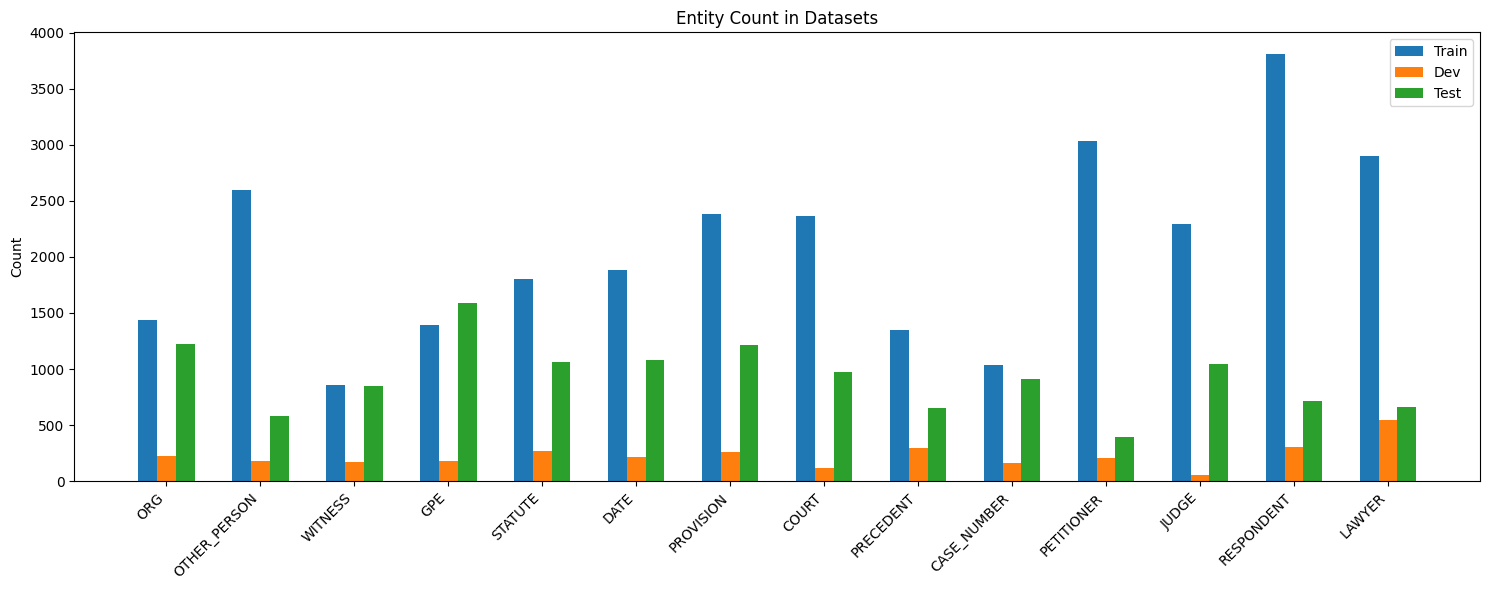

In [ ]:
plot_entity_count_in_datasets(train_ent_count, dev_ent_count, test_ent_count)

In [ ]:
import matplotlib.pyplot as plt

def plot_tag_counts(ent_count):
    sorted_items = sorted(ent_count.items(), key=lambda item: item[0])
    tags, counts = zip(*sorted_items)
    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts)
    plt.xlabel("Tags")
    plt.ylabel("Count")
    plt.title("Entity Counts")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

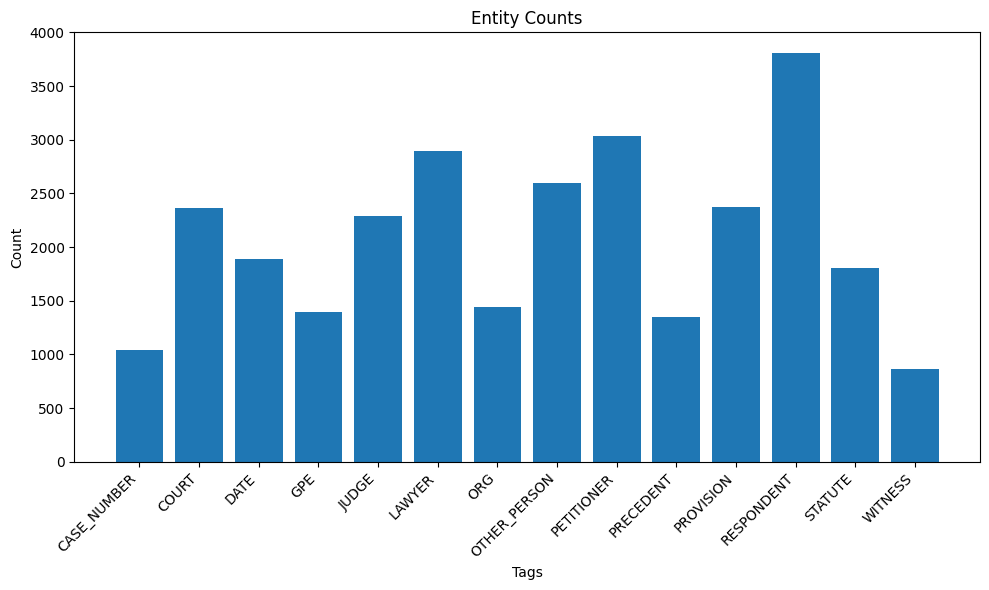

In [ ]:
plot_tag_counts(train_ent_count)

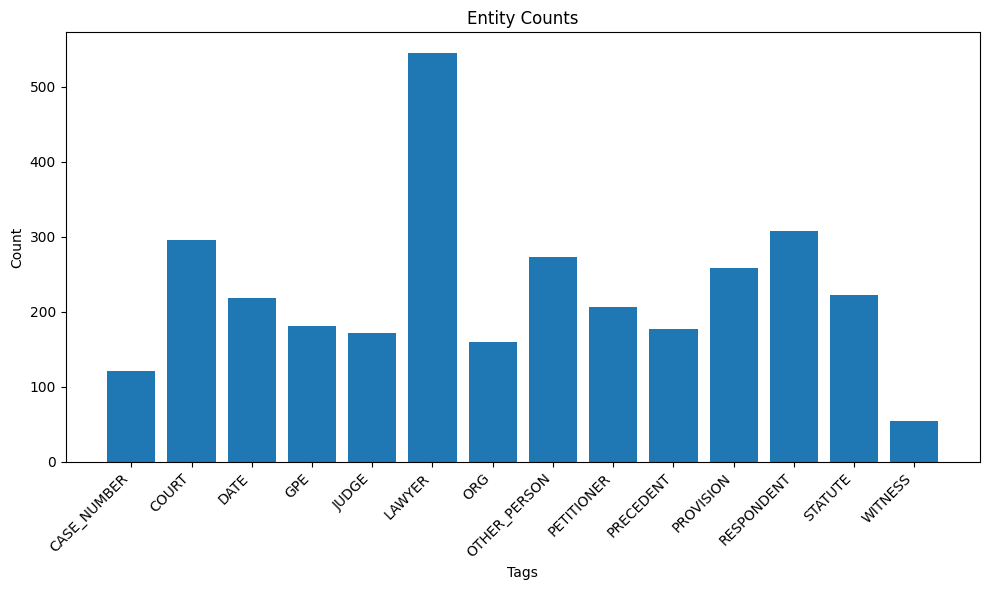

In [ ]:
plot_tag_counts(dev_ent_count)

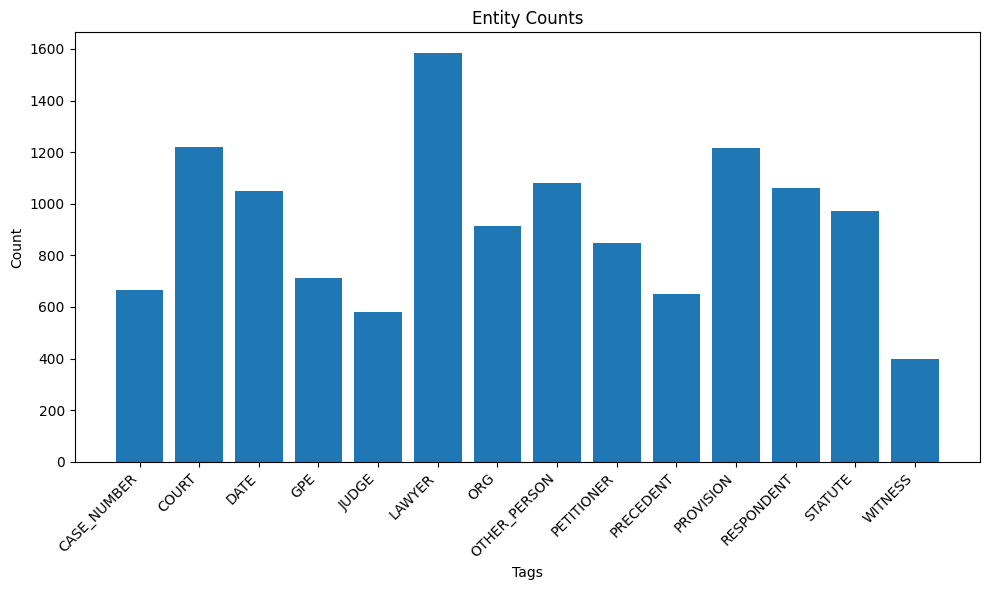

In [ ]:
plot_tag_counts(test_ent_count)

In [ ]:
def count_all_os(df):
  ctr = 0
  for _, row in df.iterrows():
      if all(tag == 'O' for tag in row['tags']):
          ctr += 1
  return ctr

In [ ]:
print(f"Count of O-only entries in train_df_formatted: {count_all_os(train_df_formatted)}")
print(f"Count of O-only entries in dev_df_formatted: {count_all_os(dev_df_formatted)}")
print(f"Count of O-only entries in test_df_formatted: {count_all_os(test_df_formatted)}")

Count of O-only entries in train_df_formatted: 2197
Count of O-only entries in dev_df_formatted: 184
Count of O-only entries in test_df_formatted: 565


In [ ]:
print(f"Number of rows in train_df_formatted: {len(train_df_formatted)}")
print(f"Number of rows in dev_df_formatted: {len(dev_df_formatted)}")
print(f"Number of rows in test_df_formatted: {len(test_df_formatted)}")

Number of rows in train_df_formatted: 10995
Number of rows in dev_df_formatted: 1074
Number of rows in test_df_formatted: 4501


In [ ]:
def drop_rows_with_only_o_tags(df):
  new_df = df.copy()
  rows_to_drop = []
  for index, row in new_df.iterrows():
    if all(tag == 'O' for tag in row['tags']):
      rows_to_drop.append(index)
  new_df = new_df.drop(rows_to_drop)
  return new_df

In [ ]:
train_df_cleaned = drop_rows_with_only_o_tags(train_df_formatted)
dev_df_cleaned = drop_rows_with_only_o_tags(dev_df_formatted)
test_df_cleaned = drop_rows_with_only_o_tags(test_df_formatted)

In [ ]:
print(f"Count of O-only entries in train_df_cleaned: {count_all_os(train_df_cleaned)}")
print(f"Count of O-only entries in dev_df_cleaned: {count_all_os(dev_df_cleaned)}")
print(f"Count of O-only entries in test_df_cleaned: {count_all_os(test_df_cleaned)}")

Count of O-only entries in train_df_cleaned: 0
Count of O-only entries in dev_df_cleaned: 0
Count of O-only entries in test_df_cleaned: 0


In [ ]:
print(f"Number of rows in train_df_cleaned: {len(train_df_cleaned)}")
print(f"Number of rows in dev_df_cleaned: {len(dev_df_cleaned)}")
print(f"Number of rows in test_df_cleaned: {len(test_df_cleaned)}")

Number of rows in train_df_cleaned: 8798
Number of rows in dev_df_cleaned: 890
Number of rows in test_df_cleaned: 3936


In [ ]:
train_df_cleaned.to_json("data_cleaned_original_split/train.json", orient="records")
dev_df_cleaned.to_json("data_cleaned_original_split/dev.json", orient="records")
test_df_cleaned.to_json("data_cleaned_original_split/test.json", orient="records")

In [ ]:
merged_df = pd.concat([dev_df_cleaned, train_df_cleaned, test_df_cleaned], ignore_index=True)

print("With duplicates:", len(merged_df))
merged_df['tokens_tuple'] = merged_df['tokens'].apply(tuple)
merged_df = merged_df.drop_duplicates(subset=['tokens_tuple'])
merged_df = merged_df.drop(['tokens_tuple'], axis=1)
print("Without duplicates:", len(merged_df))

With duplicates: 13624
Without duplicates: 13612


In [ ]:
merged_ent_count = tabulate_unique(merged_df)

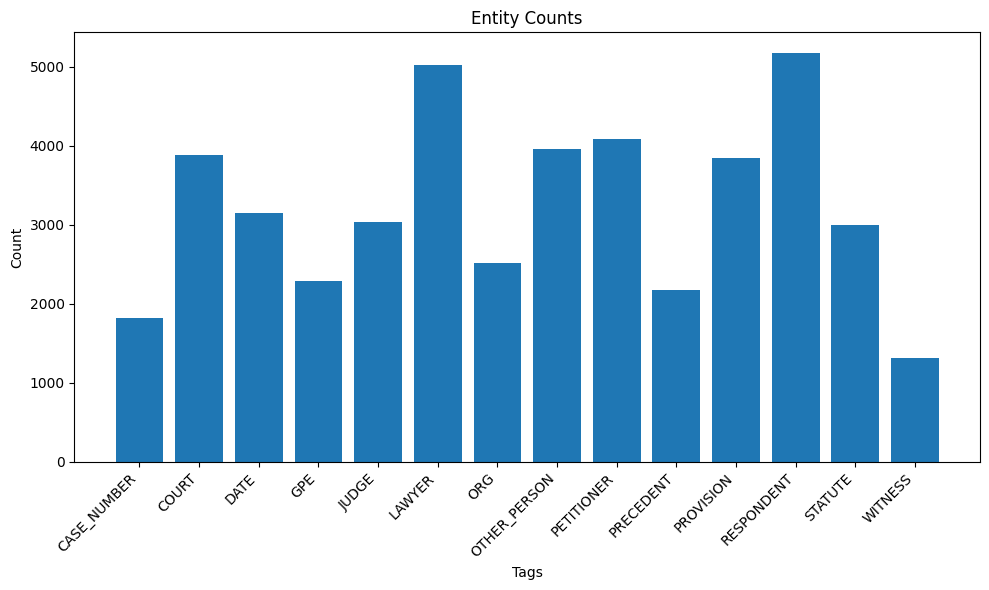

In [ ]:
plot_tag_counts(merged_ent_count)

In [ ]:
merged_df.to_json("data_cleaned_merged/dataset.json", orient="records")

In [ ]:
def get_tags_and_probs(count1, count2):
    tags = set(count1.keys()).union(set(count2.keys()))

    len1 = sum(count1.values())
    probs1 = np.array([count1.get(tag, 0) / len1 for tag in tags])
    len2 = sum(count2.values())
    probs2 = np.array([count2.get(tag, 0) / len2 for tag in tags])

    return tags, probs1, probs2

In [ ]:
from scipy.spatial.distance import jensenshannon

def compute_js_divergence(data1, data2):
    tags, probs1, probs2 = get_tags_and_probs(data1, data2)
    return jensenshannon(probs1, probs2)

In [ ]:
print("Jensen–Shannon divergence for train and dev sets: ", compute_js_divergence(train_ent_count, dev_ent_count))
print("Jensen–Shannon divergence for test and dev sets: ", compute_js_divergence(test_ent_count, dev_ent_count))
print("Jensen–Shannon divergence for train and test sets: ", compute_js_divergence(train_ent_count, test_ent_count))

Jensen–Shannon divergence for train and dev sets:  0.10590682309384077
Jensen–Shannon divergence for test and dev sets:  0.07456958453306828
Jensen–Shannon divergence for train and test sets:  0.10527845573523


In [ ]:
from sklearn.model_selection import train_test_split

def find_best_random_state(df, test_size, num_random_states):
    best_state = None
    best_divergence = float('inf')

    for random_state in range(num_random_states):
        split_train_df, split_test_df = train_test_split(df, test_size=test_size, random_state=random_state)

        split_train_ent_count = tabulate_unique(split_train_df)
        split_test_ent_count = tabulate_unique(split_test_df)

        js_divergence = compute_js_divergence(split_train_ent_count, split_test_ent_count)

        if js_divergence < best_divergence:
            best_divergence = js_divergence
            best_state = random_state

    return best_state, best_divergence

In [ ]:
best_random_state, best_divergence = find_best_random_state(merged_df, test_size=0.3, num_random_states=10000)
print(f"Best random_state: {best_random_state} with JS Divergence: {best_divergence}")

Best random_state: 3233 with JS Divergence: 0.005540222017208575


In [ ]:
new_train_df, temp_df = train_test_split(merged_df, test_size=0.3, random_state=best_random_state)

In [ ]:
new_train_ent_count = tabulate_unique(new_train_df)
temp_ent_count = tabulate_unique(temp_df)
compute_js_divergence(new_train_ent_count, temp_ent_count)

0.005540222017208575

In [ ]:
best_random_state, best_divergence = find_best_random_state(temp_df, test_size=0.5, num_random_states=10000)
print(f"Best random_state: {best_random_state} with JS Divergence: {best_divergence}")

Best random_state: 2884 with JS Divergence: 0.007388247443944045


In [ ]:
new_dev_df, new_test_df = train_test_split(temp_df, test_size=0.5, random_state=best_random_state)

In [ ]:
new_dev_ent_count = tabulate_unique(new_dev_df)
new_test_ent_count = tabulate_unique(new_test_df)
compute_js_divergence(new_dev_ent_count, new_test_ent_count)

0.007388247443944045

In [ ]:
print(f"Number of rows in new_train_df: {len(new_train_df)}")
print(f"Number of rows in new_dev_df: {len(new_dev_df)}")
print(f"Number of rows in new_test_df: {len(new_test_df)}")

Number of rows in new_train_df: 9528
Number of rows in new_dev_df: 2042
Number of rows in new_test_df: 2042


In [ ]:
new_train_ent_count = tabulate_unique(new_train_df, True)

Tag             Count
------------  -------
OTHER_PERSON     2764
COURT            2734
PRECEDENT        1513
DATE             2201
ORG              1760
STATUTE          2090
JUDGE            2121
CASE_NUMBER      1280
PETITIONER       2869
PROVISION        2697
RESPONDENT       3643
GPE              1584
WITNESS           922
LAWYER           3541


In [ ]:
new_dev_ent_count = tabulate_unique(new_dev_df, True)

Tag             Count
------------  -------
COURT             562
PETITIONER        604
RESPONDENT        744
LAWYER            724
JUDGE             457
DATE              468
OTHER_PERSON      576
PRECEDENT         327
GPE               349
ORG               368
PROVISION         571
STATUTE           441
CASE_NUMBER       264
WITNESS           187


In [ ]:
new_test_ent_count = tabulate_unique(new_test_df, True)

Tag             Count
------------  -------
WITNESS           205
OTHER_PERSON      612
PRECEDENT         336
PROVISION         579
STATUTE           462
RESPONDENT        788
DATE              481
COURT             582
CASE_NUMBER       279
GPE               353
JUDGE             461
PETITIONER        609
LAWYER            760
ORG               382


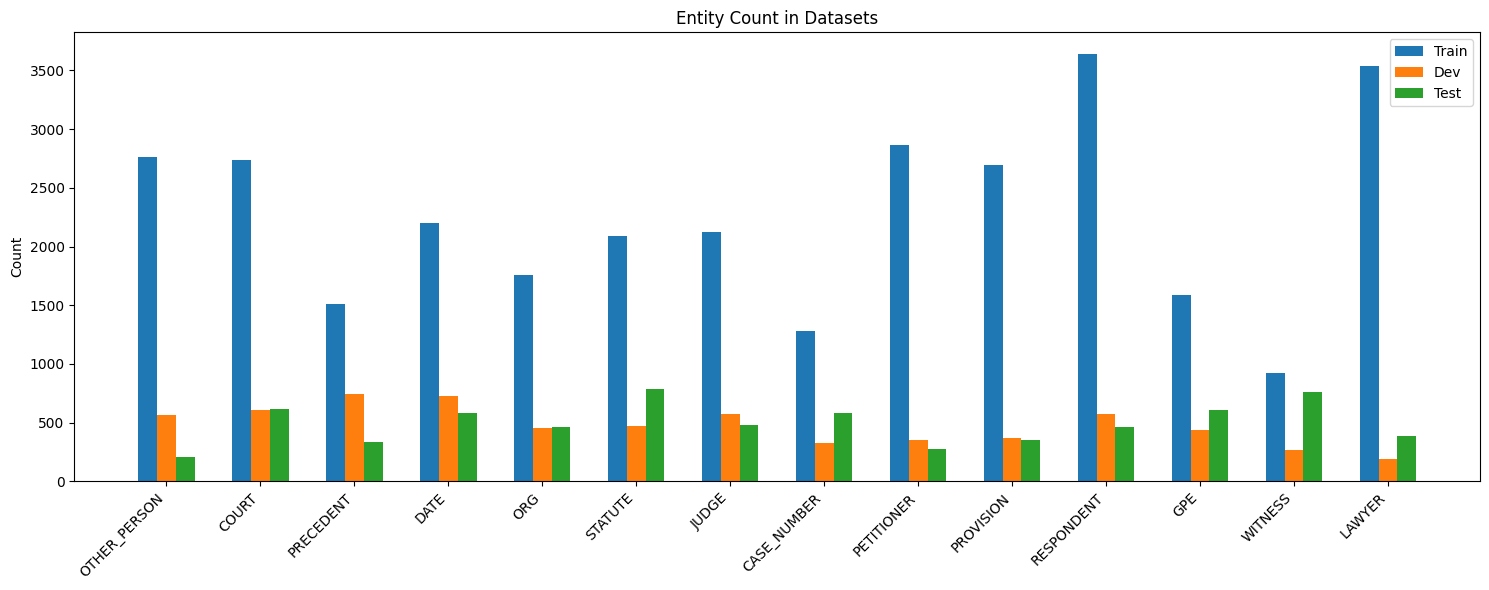

In [ ]:
plot_entity_count_in_datasets(new_train_ent_count, new_dev_ent_count, new_test_ent_count)

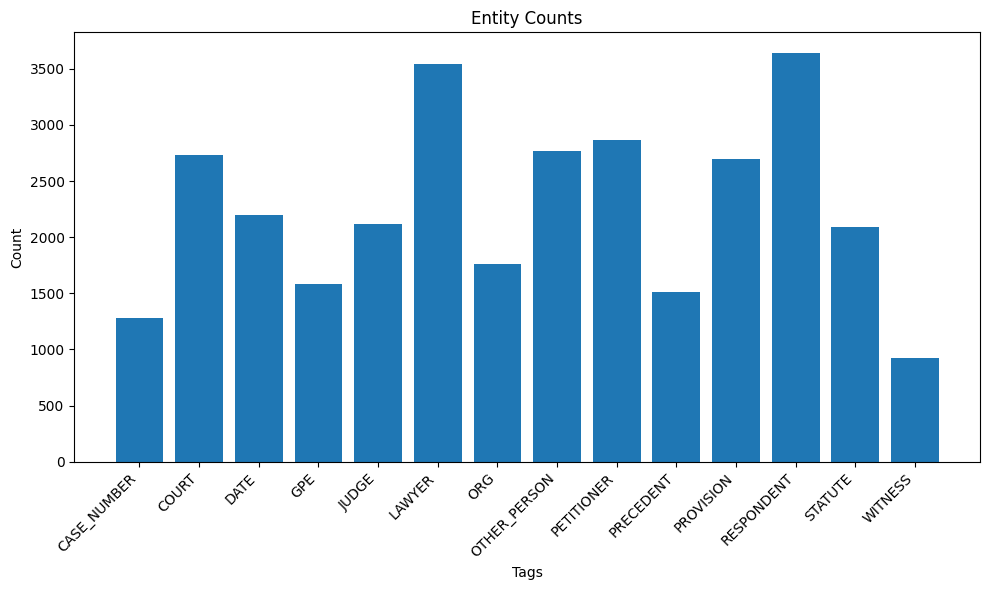

In [ ]:
plot_tag_counts(new_train_ent_count)

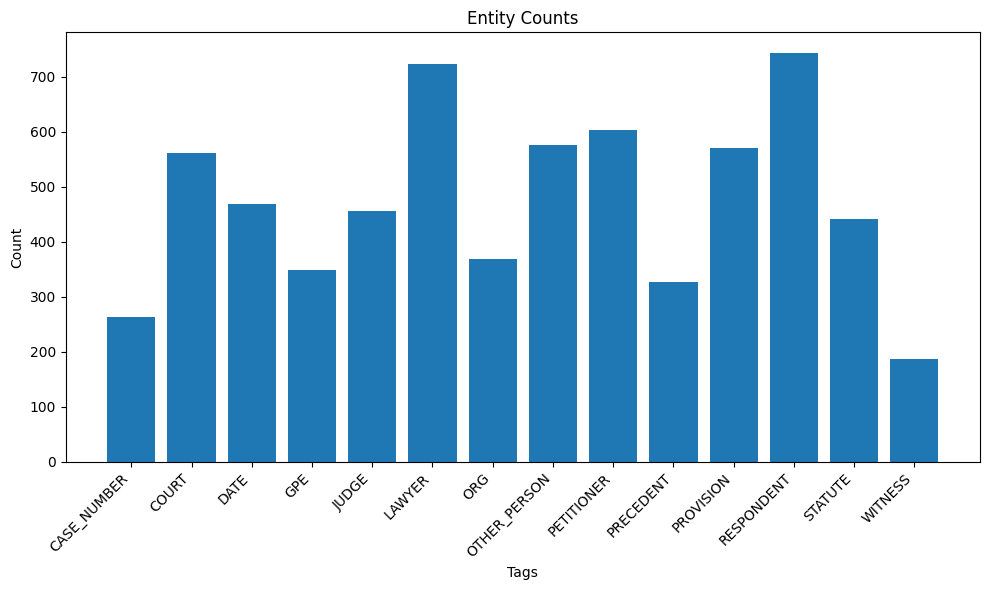

In [ ]:
plot_tag_counts(new_dev_ent_count)

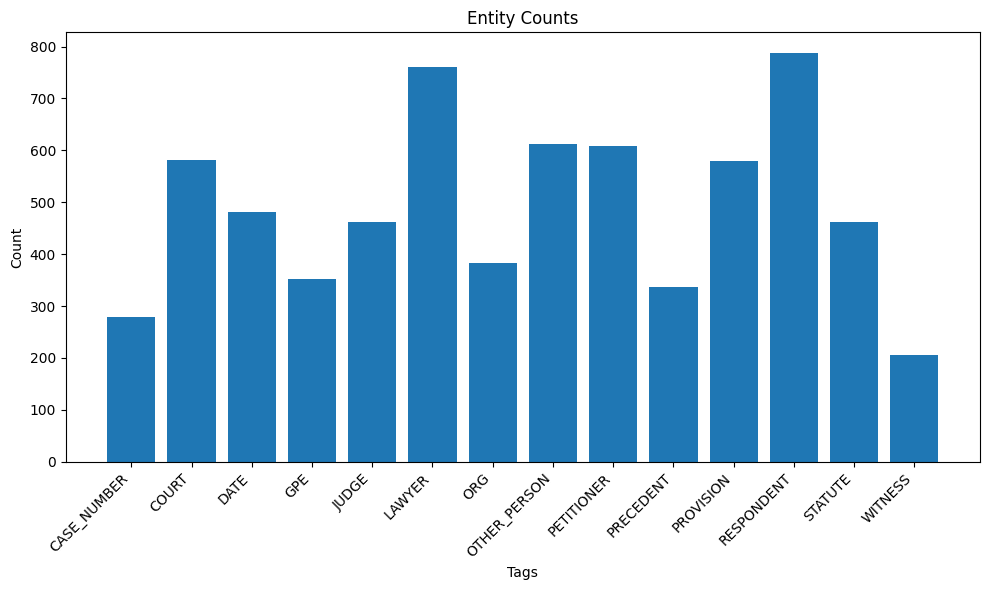

In [ ]:
plot_tag_counts(new_test_ent_count)

In [ ]:
new_train_df.to_json("data_cleaned_balanced_split/train.json", orient="records")
new_dev_df.to_json("data_cleaned_balanced_split/dev.json", orient="records")
new_test_df.to_json("data_cleaned_balanced_split/test.json", orient="records")